In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from collections import Counter
from torchvision import datasets, transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import os



In [6]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda


In [7]:
from torchvision import datasets
from PIL import Image
from collections import Counter
import os

# Path to the structured training folder
data_dir = '/kaggle/input/brain-tumor-dataset/Brain_Tumor/Training'

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir)

# Class names and their order
print("Class names:", dataset.classes)

# Count images per class
class_counts = Counter([label for _, label in dataset.samples])
print(f"\nClass distribution: {class_counts}")

# Show image sizes
print("\nImage sizes (first 5):")
for i in range(5):
    img_path, label = dataset.samples[i]
    with Image.open(img_path) as img:
        print(f"Image {i}: {img.size} (Class: {dataset.classes[label]})")

Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']

Class distribution: Counter({2: 1595, 3: 1457, 1: 1339, 0: 1321})

Image sizes (first 5):
Image 0: (512, 512) (Class: glioma)
Image 1: (512, 512) (Class: glioma)
Image 2: (512, 512) (Class: glioma)
Image 3: (512, 512) (Class: glioma)
Image 4: (512, 512) (Class: glioma)


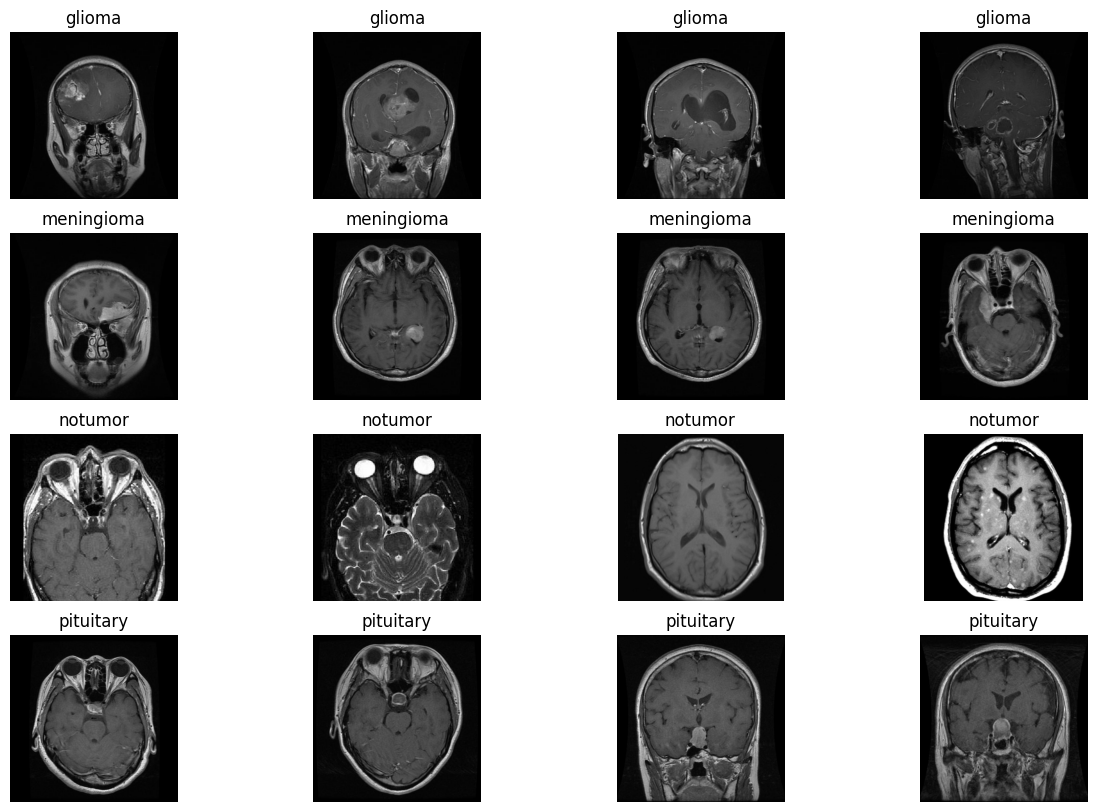

In [8]:
# Function to plot samples
def plot_samples(dataset, num_samples=4):
    fig, axes = plt.subplots(4, num_samples, figsize=(15, 10))
    for i, class_name in enumerate(dataset.classes):
        class_indices = [idx for idx, (_, label) in enumerate(dataset.samples) if label == i]
        for j in range(num_samples):
            img_path, _ = dataset.samples[class_indices[j]]
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].set_title(f'{class_name}')
            axes[i, j].axis('off')
    plt.show()

# Display samples
plot_samples(dataset)
    

Training images: 5712
Training dataset Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Testing images: 1311


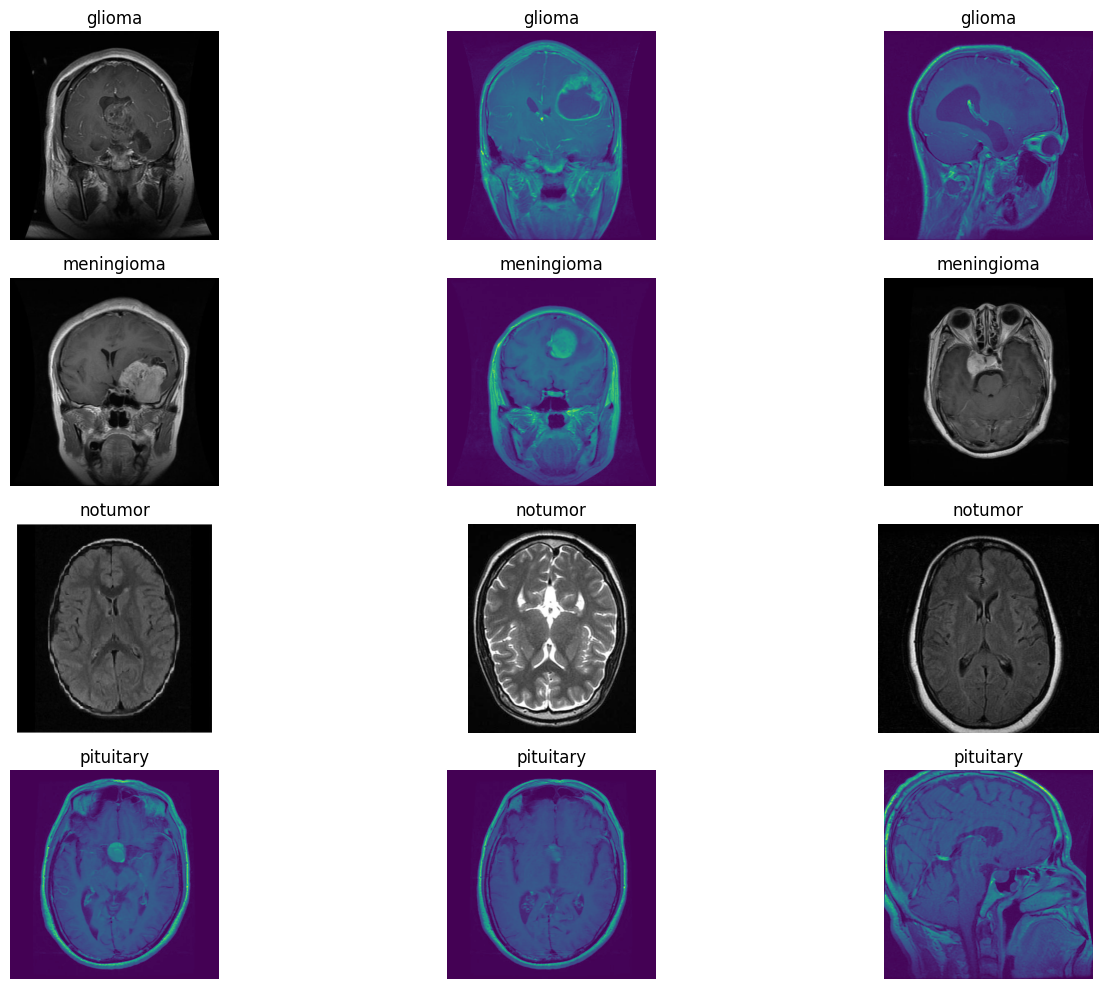

In [9]:
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
from pathlib import Path
import os

# Define the correct dataset paths
data_dir_training = '/kaggle/input/brain-tumor-dataset/Brain_Tumor/Training'
data_dir_testing = '/kaggle/input/brain-tumor-dataset/Brain_Tumor/Testing'

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load training dataset using ImageFolder
dataset_training = datasets.ImageFolder(root=data_dir_training, transform=transform)

# Explore the dataset
print(f'Training images: {len(dataset_training)}')
print(f'Training dataset Classes: {dataset_training.classes}')

# Since testing folder has no class folders, we just count files manually
test_img_files = list(Path(data_dir_testing).glob('*.jpg')) + list(Path(data_dir_testing).glob('*.png'))
print(f'Testing images: {len(test_img_files)}')

# Visualize sample images from the training dataset
train_dir = Path(data_dir_training)
class_names = dataset_training.classes

plt.figure(figsize=(15, 10))

# Show 3 random images from each class
for i, class_name in enumerate(class_names, 1):
    class_path = train_dir / class_name
    image_files = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))

    selected_images = random.sample(image_files, min(3, len(image_files)))

    for j, img_path in enumerate(selected_images, 1):
        ax = plt.subplot(4, 3, (i - 1) * 3 + j)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f'{class_name}')
        plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from pathlib import Path
import os

# Define transformations for training (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for testing (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load training dataset using ImageFolder and apply transform
data_dir_training = '/kaggle/input/brain-tumor-dataset/Brain_Tumor/Training'
dataset_training = datasets.ImageFolder(root=data_dir_training, transform=train_transform)

# Custom Dataset for unlabeled test images
class TestImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.image_paths = list(self.image_dir.glob('*.jpg')) + list(self.image_dir.glob('*.png'))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path.name  # return filename for submission

# Load the test set using the custom dataset
data_dir_testing = '/kaggle/input/brain-tumor-dataset/Brain_Tumor/Testing'
dataset_testing = TestImageDataset(image_dir=data_dir_testing, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(dataset_training, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_testing, batch_size=32, shuffle=False)

In [11]:
batch_size = 32
epochs = 50
learning_rate = 0.001

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

class TumorClassifier(nn.Module):
    def __init__(self):
        super(TumorClassifier, self).__init__()
        
        # Enhanced convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Global average pooling instead of flattening
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Enhanced fully connected layers with dropout
        self.fc1 = nn.Linear(128, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 4)  # 4-class classification
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Feature extraction
        x = torch.relu(self.bn1(self.conv1(x)))
        x = nn.MaxPool2d(2, 2)(x)
        
        x = torch.relu(self.bn2(self.conv2(x)))
        x = nn.MaxPool2d(2, 2)(x)
        
        x = torch.relu(self.bn3(self.conv3(x)))
        x = nn.MaxPool2d(2, 2)(x)
        
        # Global average pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        # Classification
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x

# Instantiate model
model = TumorClassifier()

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

# Define loss and optimizer with weight decay (L2 regularization)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

TumorClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)


In [13]:
# Set model to evaluation mode
model.eval()

# Store predictions as (image_name, predicted_label)
predictions = []

# No gradient calculation needed during inference
with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Collect results
        for fname, label in zip(filenames, predicted.cpu().numpy()):
            predictions.append([fname, label])

# Create submission DataFrame
submission_df = pd.DataFrame(predictions, columns=['image_name', 'label'])

# Optional: sort by image name (recommended for consistency)
submission_df = submission_df.sort_values(by='image_name').reset_index(drop=True)

# Save to CSV
submission_df.to_csv('submission.csv', index=False)
print("Saved submission.csv successfully.")

Saved submission.csv successfully.


In [14]:
print('hello')

hello


In [15]:
checkpoint = torch.load("/kaggle/input/brain_tumor_prediction_model/pytorch/default/1/best_model.pth")

#model = MyModel()  # define model architecture same as before
#optimizer = torch.optim.Adam(model.parameters())  # or same optimizer used

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']
accuracy = checkpoint['accuracy']

model.eval()  # or model.train() depending on usage

/tmp/ipykernel_84/1643118918.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/brain_tumor_prediction_model/pytorch/default/1/best_m

TumorClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

NameError: name 'train_label_zip' is not defined

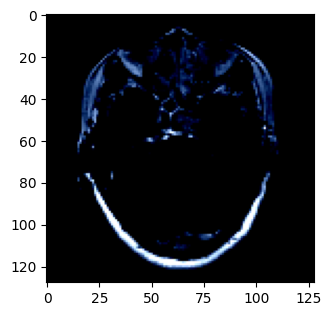

In [16]:
from itertools import islice
import matplotlib.pyplot as plt
from PIL import Image
import torch

plt.figure(figsize=(12, 16))  # Adjust figure size as needed


with torch.no_grad():
    # Track the overall subplot position
    subplot_pos = 1
    
    for batch_idx, (images, filenames) in enumerate(islice(test_loader, 4)):  # Show 4 batches
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu().numpy()
        
        # Show 3 images per batch (adjust as needed)
        for j in range(min(3, len(predicted))):  # Ensure we don't exceed batch size
            ax = plt.subplot(4, 3, subplot_pos)  # 4 batches x 3 images each
            
            # Convert tensor to numpy image if needed
            if torch.is_tensor(images[j]):
                img = images[j].cpu().permute(1, 2, 0).numpy()
                if img.shape[2] == 1:  # Grayscale
                    img = img.squeeze()
            else:
                img = Image.open(filenames[j])  # If your loader returns filenames
            for i, class_name in enumerate(class_names, 1):
                class_path = train_dir / class_name
                image_files = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))
              
            plt.imshow(img)
            plt.title(f'Pred: {class_names[predicted[j]]}\n True: ({train_label_zip[j]})')
            plt.axis('off')
            
            subplot_pos += 1  # Move to next subplot position

plt.tight_layout()
plt.show()

In [ ]:
train_csv = pd.read_csv('/kaggle/input/sample-train-and-test-dataset/train.csv')
display(train_csv.head())

train_label_zip = dict(zip(train_csv['image_name'], train_csv['label']))

In [ ]:
# Set model to evaluation mode
model.eval()

# Store predictions as (image_name, predicted_label)
predictions = []

# No gradient calculation needed during inference
with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Collect results
        for fname, label in zip(filenames, predicted.cpu().numpy()):
            predictions.append([fname, label])
            
            
            plt.figure(figsize=(12, 8), dpi=300)

# Set the number of images to display
num_images = 20
rows = 4
cols = 5

# Get random indices
random_indices = random.sample(range(len(dataset_testing)), num_images)

# Plot images in grid
for i, idx in enumerate(random_indices):
    plt.subplot(rows, cols, i+1)
    
    # Get the image and label - assuming your dataset returns (image, label) tuples
    image, true_label = dataset_testing[idx]  # This is the correct way to access dataset items
    
    # For PyTorch tensors, we need to permute dimensions and convert to numpy
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()  # Convert CxHxW to HxWxC
        if image.shape[2] == 1:  # Grayscale image
            image = image.squeeze()  # Remove channel dimension
    
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.title(f'True: {true_label}\nPred: {predictions[class_name]}', fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

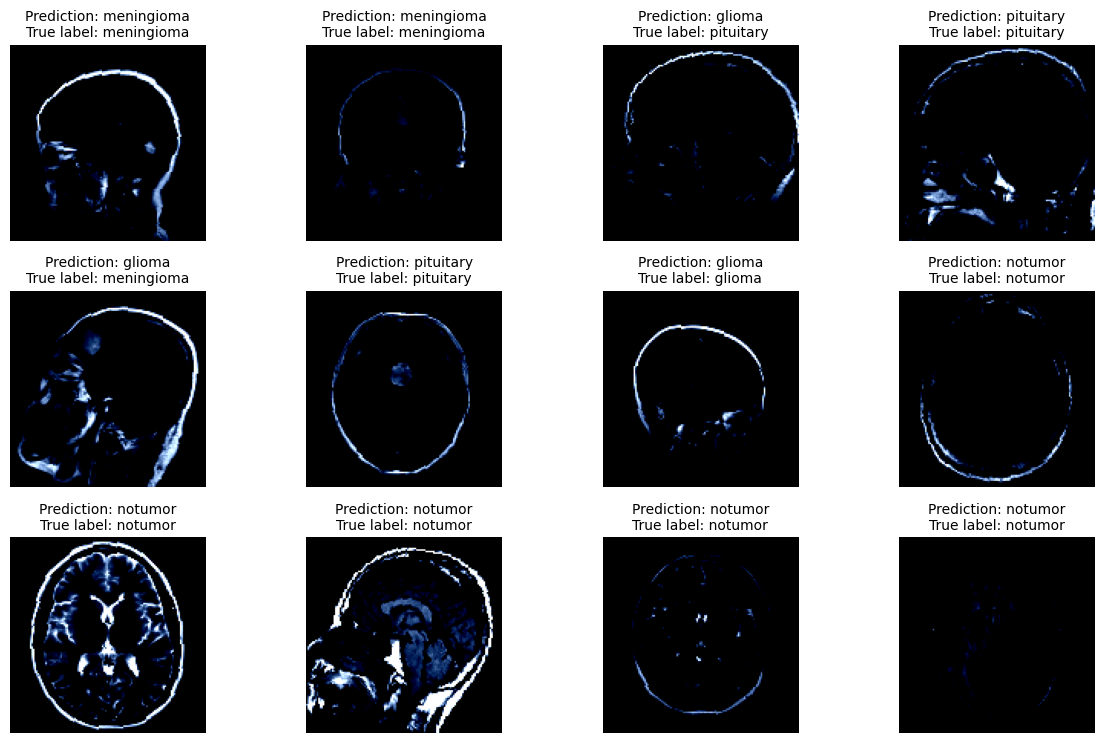

In [28]:
from itertools import islice
import matplotlib.pyplot as plt
import torch
from pathlib import Path

plt.figure(figsize=(12, 10))  # Adjust figure size as needed

with torch.no_grad():
    subplot_pos = 1
    
    for batch_idx, (images, labels) in enumerate(islice(train_loader, 4)):  # Show 4 batches
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu().numpy()
        true_labels = labels.cpu().numpy()  # Convert tensor labels to numpy array
        
        # Show 3 images per batch
        for j in range(min(3, len(predicted))):  # Ensure we don't exceed batch size
            ax = plt.subplot(4, 4, subplot_pos)
            
            # Convert tensor to displayable image
            img = images[j].cpu().permute(1, 2, 0).numpy()
            if img.shape[2] == 1:  # Grayscale
                img = img.squeeze()
            
            # Get class names
            pred_class = class_names[predicted[j]]
            true_class = class_names[true_labels[j]]
            
            plt.imshow(img)
            plt.title(f'Prediction: {pred_class}\nTrue label: {true_class}', fontsize=10)
            plt.axis('off')
            
            subplot_pos += 1

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 8), dpi=300)

# Set the number of images to display
num_images = 20
rows = 4
cols = 5

# Get random indices
random_indices = random.sample(range(len(dataset_tes)), num_images)

# Plot images in grid
for i, idx in enumerate(random_indices):
    plt.subplot(rows, cols, i+1)
    
    # Get the image and label - assuming your dataset returns (image, label) tuples
    image, true_label = dataset_testing[idx]  # This is the correct way to access dataset items
    
    # For PyTorch tensors, we need to permute dimensions and convert to numpy
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()  # Convert CxHxW to HxWxC
        if image.shape[2] == 1:  # Grayscale image
            image = image.squeeze()  # Remove channel dimension
    
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.title(f'True: {true_label}\nPred: {predictions[class_name]}', fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import time
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training parameters
epochs = 50
best_train_acc = 0.0

# Training history storage
history = {
    'train_loss': [],
    'train_acc': []
}

# Training loop
for epoch in range(epochs):
    start_time = time.time()
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print batch progress every 20 batches
        if batch_idx % 20 == 0:
            batch_acc = (predicted == labels).sum().item() / labels.size(0)
            print(f'Epoch {epoch+1}/{epochs} | Batch {batch_idx}/{len(train_loader)} | '
                  f'Batch Loss: {loss.item():.4f} | Batch Acc: {batch_acc:.4f}')

    # Epoch statistics
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    epoch_time = time.time() - start_time
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Print epoch summary
    print(f'\nEpoch {epoch+1}/{epochs} - {epoch_time:.2f}s')
    print(f'Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}')
    
    # Save best model
    if train_acc > best_train_acc:
        print(f'Training accuracy improved from {best_train_acc:.4f} to {train_acc:.4f}')
        best_train_acc = train_acc
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            'accuracy': train_acc
        }, 'best_model.pth')
    
    print('-' * 60)

print(f'\nTraining complete. Best training accuracy: {best_train_acc:.4f}')